# Первое задание по вычислительной математике. Жесткие системы ОДУ и их решения

In [28]:
# Подключаем заклинания
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sympy import diff, symbols, Symbol, integrate, solve, sqrt, log, sin, cos, lambdify
from scipy.integrate import solve_ivp
from scipy import sqrt
from spellbook import *
import seaborn as sns
%matplotlib inline
sns.set()

Вводим систему и начальные условия из задания

In [29]:
def f(t, y):
    return np.array([
        -1.71*y[0] + 0.43*y[1] + 8.23*y[2] + 0.0007,
        1.71*y[0] - 8.75*y[1],
        -10.03*y[2] + 0.43*y[3] + 0.035*y[4],
        8.32*y[1] + 1.71*y[2] - 1.12*y[3],
        -1.745*y[4] + 0.43*y[5] + 0.43*y[6],
        -280*y[5]*y[7] + 0.69*y[3] + 1.71*y[4] - 0.43*y[5] + 0.69*y[6],
        280*y[5]*y[7] - 1.87*y[6],
        -280*y[5]*y[7] + 1.87*y[6]
    ])

t0, te = 0, 421.8122
tol_newton = 1e-9
init = array([1, 0, 0, 0, 0, 0, 0, 0.0057])

## Часть 0. Эталонное решение
В качестве образца использован метод Гаусса

In [30]:
n_steps = 40000
gauss = Gauss(f, init, t0, te, n_steps, tol_newton)

In [31]:
gauss.solve()

100%|██████████| 40001/40001 [04:35<00:00, 145.26it/s]


Визуализируем зависимость всех переменных от времени

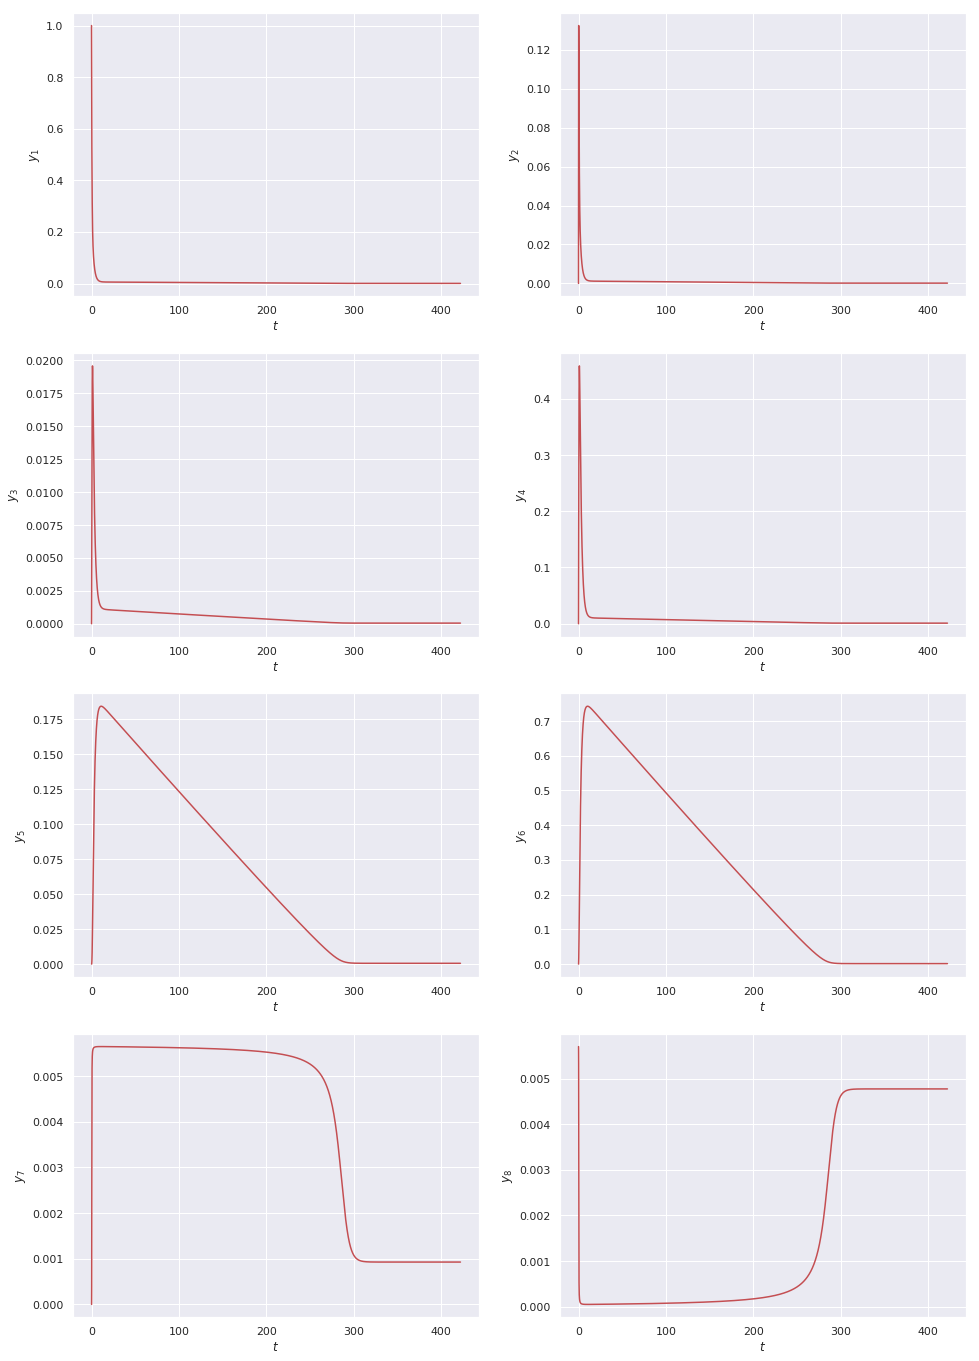

In [32]:
paragon = np.array(gauss.solution)
fig, axes = plt.subplots(4,2, figsize=(16, 24))
for i, ax in enumerate(axes.flatten()):
    ax.plot(paragon[:, 0], paragon[:, i+1], 'r-')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$y_{'+str(i+1)+'}$')
plt.show()

## Часть 1. Неявные методы Рунге-Кутты

Имплементируем методы из задания

In [33]:
s = sqrt(2)
class SDIRK1(RungeImplicit):
    A = array([[0.5*(2+s), 0],
               [-s, 0.5*(2+s) ]])
    b = array([0.5, 0.5])
    c = array([0.5*(2+s), 0.5*(2-s)])

class SDIRK2(RungeImplicit):
    A = array([[0.5*(2-s), 0],
               [s, 0.5*(2-s) ]])
    b = array([0.5, 0.5])
    c = array([0.5*(2-s), 0.5*(2+s)])

q = sqrt(3)
class SDIRK3(RungeImplicit):
    A = array([[(1/6)*(3+q), 0],
               [(1/6)*(3-2*q), (1/6)*(3+q)]])
    b = array([0.5, 0.5])
    c = array([(1/6)*(3+q), (1/6)*(3-q)])

In [34]:
n_steps = 40000
sdirk1 = SDIRK1(f, init, t0, te, n_steps, tol_newton)
sdirk2 = SDIRK2(f, init, t0, te, n_steps, tol_newton)
sdirk3 = SDIRK3(f, init, t0, te, n_steps, tol_newton)

И получим решения системы

In [35]:
%%time
sdirk1.solve()

100%|██████████| 40001/40001 [04:35<00:00, 145.38it/s]

CPU times: user 12min 25s, sys: 22min 53s, total: 35min 19s
Wall time: 4min 35s


In [36]:
%%time
sdirk2.solve()

100%|██████████| 40001/40001 [04:44<00:00, 140.47it/s]

CPU times: user 12min 46s, sys: 23min 23s, total: 36min 10s
Wall time: 4min 44s


In [37]:
%%time
sdirk3.solve()

100%|██████████| 40001/40001 [04:33<00:00, 162.00it/s]

CPU times: user 12min 25s, sys: 23min 2s, total: 35min 28s
Wall time: 4min 33s


## Часть 2. Формулы дифференцирования назад
Выполним все действия предыдущего пункта для формул дифференцирования назад

In [84]:
bdf_sol = solve_ivp(f, (t0, te), init.copy(), method='BDF', t_eval=np.linspace(t0, te, n_steps))
bdf_sol = np.vstack((bdf_sol.t, bdf_sol.y)).T

## Часть 3. Сравнение результатов

Для сравнения результатов с эталоном рассчитаем абсолютную ошибку по переменным $y_3$, $y_5$, $y_8$ и визуализируем её

In [85]:
solutions  = {'SDIRK1': array(sdirk1.solution), 'SDIRK2':array(sdirk2.solution), 'SDIRK3':array(sdirk3.solution), 'BDF':bdf_sol}

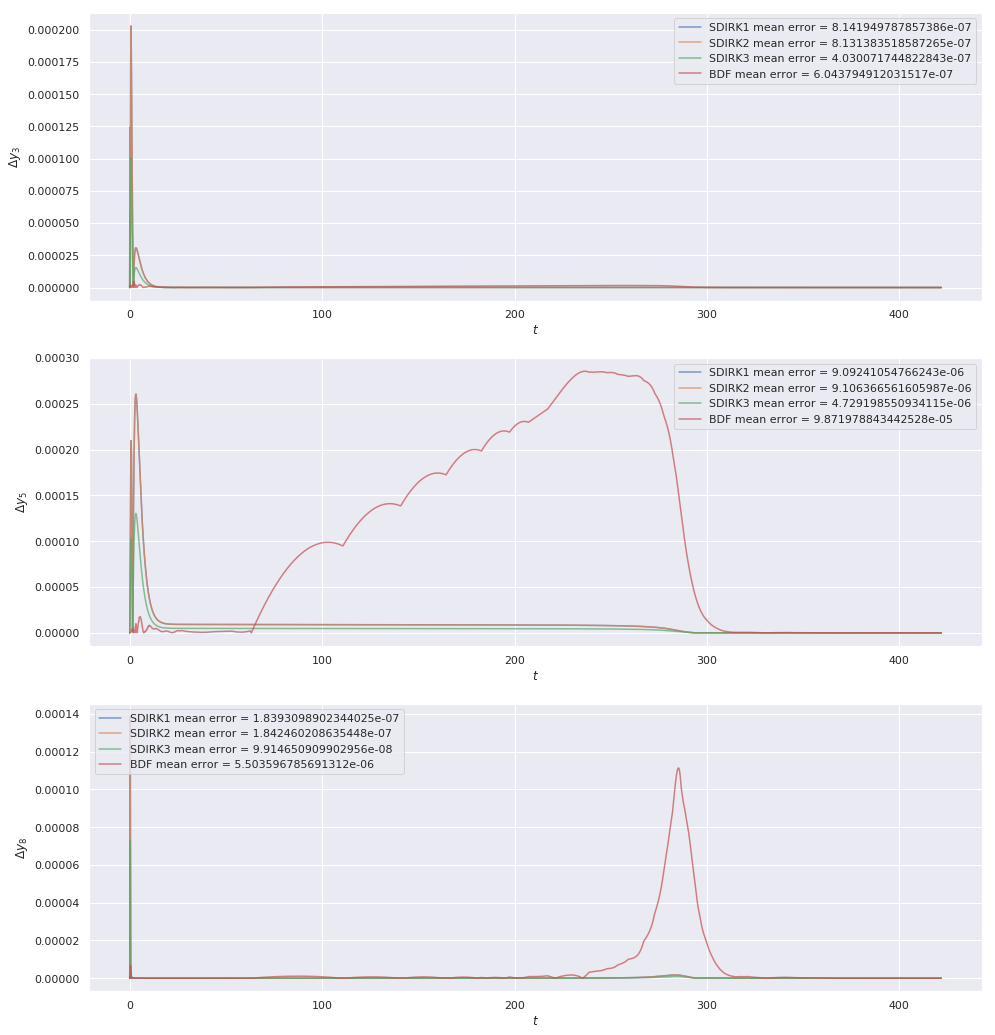

In [86]:
fig, axes = plt.subplots(3,1, figsize=(16, 18))
var = [3, 5, 8]
for i, ax in enumerate(axes.flatten()):
    for model in solutions:
        differ = np.abs(solutions[model][:, var[i]][:n_steps] - paragon[:, var[i]][:n_steps])
        ax.plot(paragon[:, 0][:n_steps], differ[:n_steps], label=model+' mean error = {}'.format(differ.mean()), alpha=0.7)
    ax.legend()
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$\Delta y_{'+str(var[i])+'}$')

Можно видеть, что среди исследованных методов наиболее высокое качество показал SDIRK3, который имеет третий порядок аппроксимации.